Install libraries:



*   pip install scanpy
*   pip install leidenalg



In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
filename = '......./20200804_NasalSwab_Broad_BCH_UMMC_to_CZI.h5ad'
ann = sc.read(filename, backed=None, sheet=None, ext=None, delimiter=None, first_column_names=False, backup_url=None, cache=False)

In [ ]:
#Covid dataset
covid = ann[ann.obs["Disease"] == "COVID19", :]
nocovid = ann[ann.obs["Disease"] == "Control", :]

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.0 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.3 leidenalg==0.8.3


In [ ]:
ann.obs.Annotation.unique()

['CACNA1A high Cells', 'Ciliated Cells BEST4 high', 'Secretory Cells 2', 'Secretory Cells 1', 'Deuterosomal Cells', ..., 'Basal Cells', 'Ciliated Cells Interferon Responsive', 'Secretory Cells 3', 'Secretory Cells 5', 'Cytokine Secreting Macrophages']
Length: 21
Categories (21, object): ['CACNA1A high Cells', 'Ciliated Cells BEST4 high', 'Secretory Cells 2',
                          'Secretory Cells 1', ..., 'Ciliated Cells Interferon Responsive',
                          'Secretory Cells 3', 'Secretory Cells 5', 'Cytokine Secreting Macrophages']

normalizing counts per cell
    finished (0:00:00)


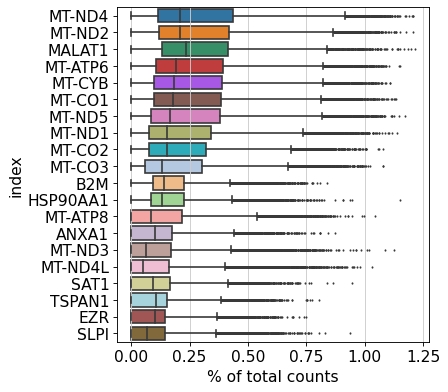

In [ ]:
sc.pl.highest_expr_genes(ann, n_top=20, )

In [ ]:
sc.pp.filter_cells(ann, min_genes=200)
sc.pp.filter_genes(ann, min_cells=3)

filtered out 859 cells that have less than 200 genes expressed
filtered out 4722 genes that are detected in less than 3 cells


In [ ]:
ann.var['mt'] = ann.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ann, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

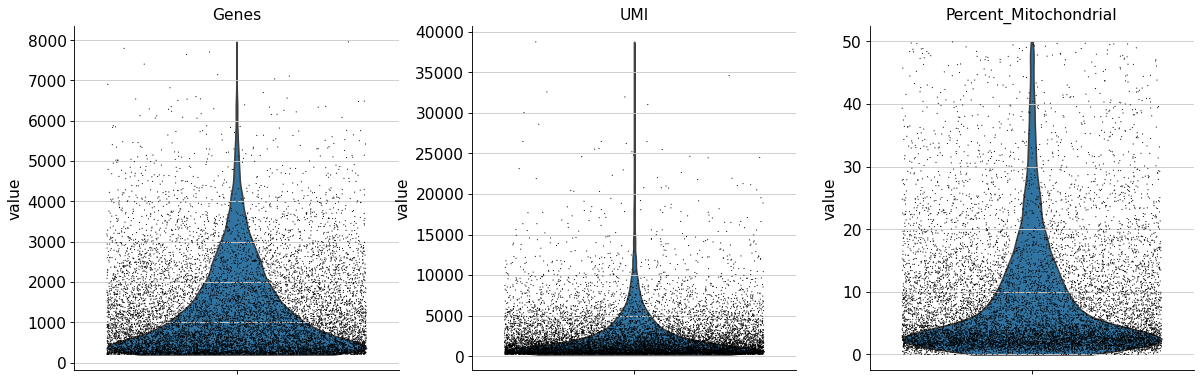

In [ ]:
sc.pl.violin(ann, ['Genes', 'UMI', 'Percent_Mitochondrial'],
             jitter=0.4, multi_panel=True)

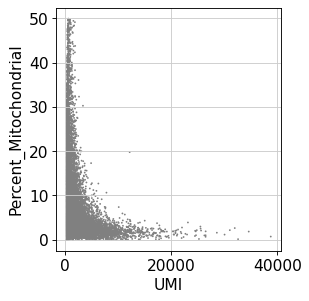

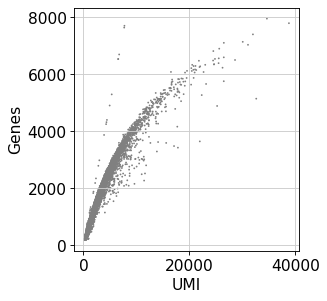

In [ ]:
sc.pl.scatter(ann, x='UMI', y='Percent_Mitochondrial')
sc.pl.scatter(ann, x='UMI', y='Genes')

In [ ]:
ann = ann[ann.obs.Genes < 2500, :]
ann = ann[ann.obs.Percent_Mitochondrial < 5, :]

In [ ]:
sc.pp.normalize_total(ann, target_sum=1e4)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


In [ ]:
sc.pp.log1p(ann)

In [ ]:
sc.pp.highly_variable_genes(ann, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


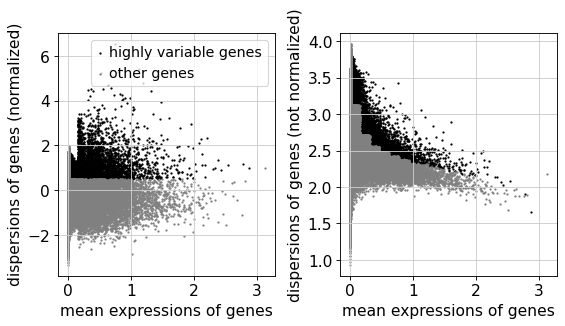

In [ ]:
sc.pl.highly_variable_genes(ann)

In [ ]:
ann.raw = ann

In [ ]:
ann = ann[:, ann.var.highly_variable]

In [ ]:
sc.pp.regress_out(ann, ['UMI', 'Percent_Mitochondrial'])

regressing out ['UMI', 'Percent_Mitochondrial']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:52)


In [ ]:
sc.pp.scale(ann, max_value=10)

In [ ]:
sc.tl.pca(ann, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:08)


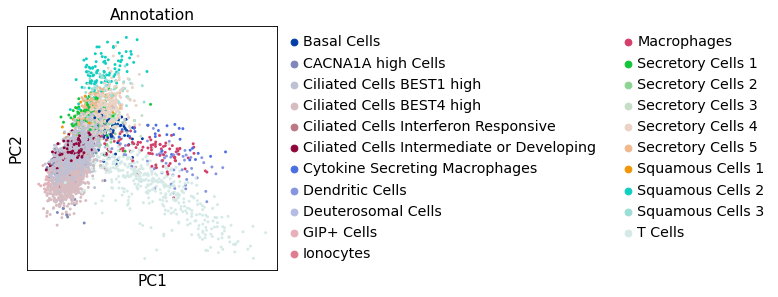

In [ ]:
sc.pl.pca(ann, color='Annotation')

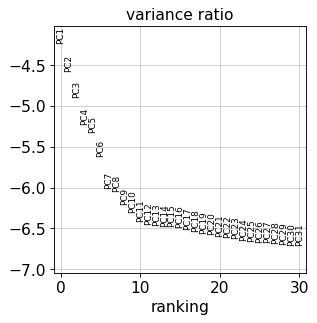

In [ ]:
sc.pl.pca_variance_ratio(ann, log=True)

In [ ]:
sc.pp.neighbors(ann) 

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [ ]:
sc.tl.umap(ann)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


Clustering the neighborhood graph

In [ ]:
sc.tl.leiden(ann)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


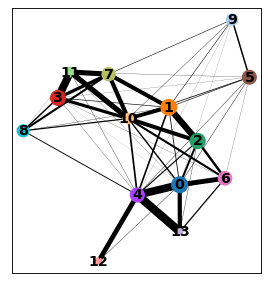

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [ ]:
sc.tl.paga(ann)
sc.pl.paga(ann, )  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(ann, init_pos='paga' )

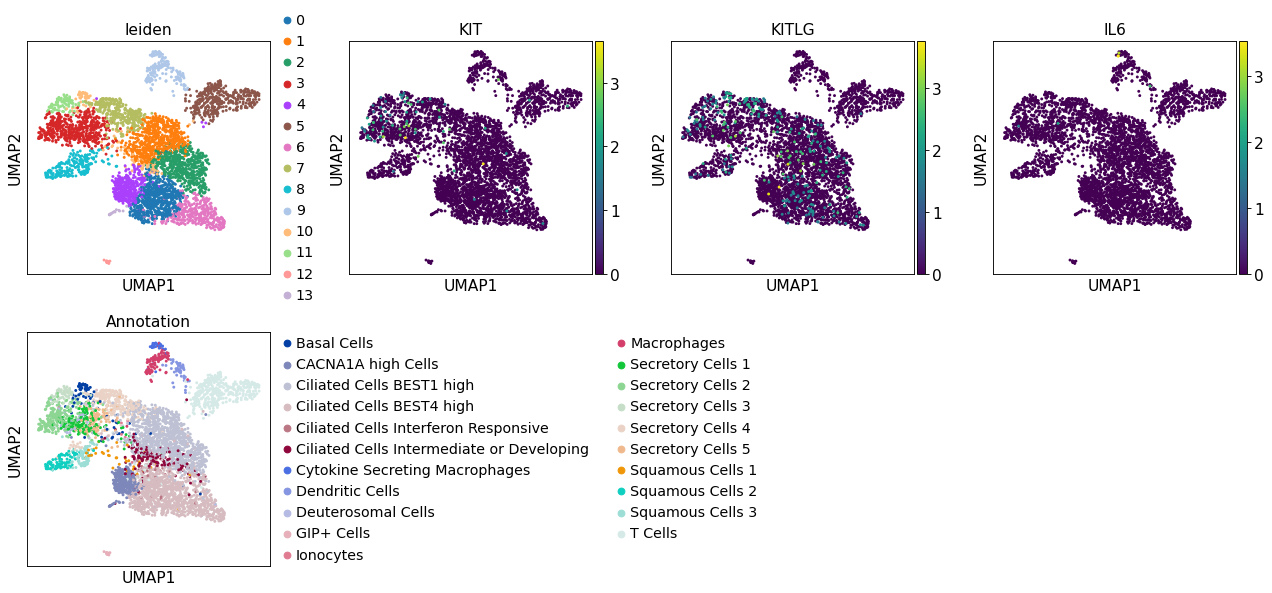

In [ ]:
sc.pl.umap(ann, color=['leiden', 'KIT', 'KITLG', 'IL6', 'Annotation'])

**Finding marker genes**
ranking for the highly differential genes in each cluster

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:06)


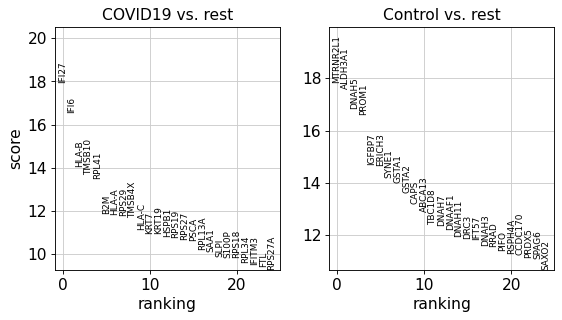

In [ ]:
#Wilcoxon rank-sum (Mann-Whitney-U) test

sc.tl.rank_genes_groups(ann, 'Disease', method='wilcoxon')
sc.pl.rank_genes_groups(ann, n_genes=25, sharey=False)

In [ ]:
#10 top ranked genes per cluster

pd.DataFrame(ann.uns['rank_genes_groups']['names']).head(5)

,COVID19,Control
0,IFI27,MTRNR2L1
1,IFI6,ALDH3A1
2,HLA-B,DNAH5
3,TMSB10,PROM1
4,RPL41,IGFBP7


In [ ]:
result = ann.uns['rank_genes_groups']
groups = result['names'].dtype.names
expr = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

In [ ]:
names  =[]
pvals = []
pvals_adj = []
logFC = []

for i in range(len(result['names'])):
  for name in result['names'][i]:
      names.append(name)
  for pval in result['pvals'][i]:
      pvals.append(pval)
  for pval_adj in result['pvals_adj'][i]:
      pvals_adj.append(pval_adj)
  for fc in result['logfoldchanges'][i]:
      logFC.append(fc)

wilcoxon = pd.DataFrame(
    {'genes': names,
     'pvals': pvals,
     'pvals_adj': pvals_adj,
     'logFC': logFC
    })


In [ ]:
wilcoxon[wilcoxon['genes'].isin(['KIT', 'KITLG'] )]

,genes,pvals,pvals_adj,logFC
2964,KIT,0.507612,1.0,1.76757
13672,KITLG,0.956981,1.0,0.10843
41661,KITLG,0.956981,1.0,-0.10843
52369,KIT,0.507612,1.0,-1.76757


ranking genes
    finished (0:00:01)


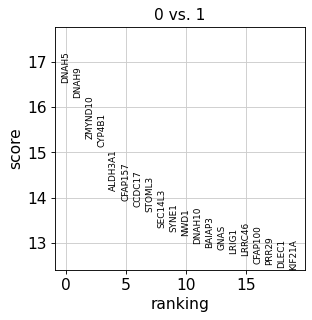

In [ ]:
#Compare to a single cluster

sc.tl.rank_genes_groups(ann, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(ann, groups=['0'], n_genes=20)

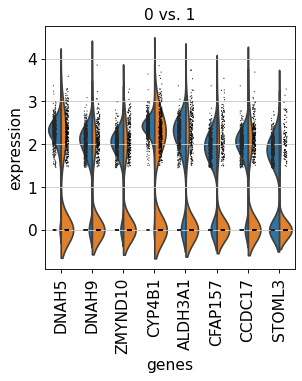

In [ ]:
sc.pl.rank_genes_groups_violin(ann, groups='0', n_genes=8)

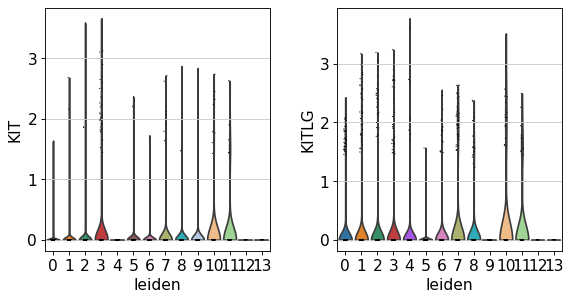

In [ ]:
sc.pl.violin(ann, ['KIT', 'KITLG'], groupby='leiden')

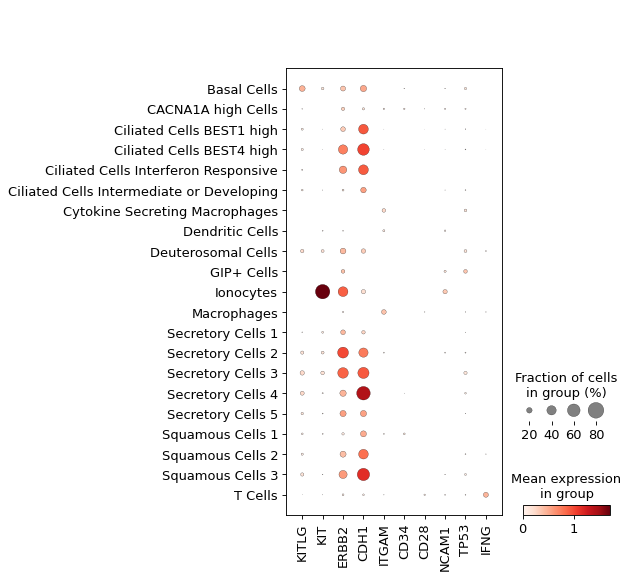

In [ ]:
marker_genes = ['KITLG', 'KIT', 'ERBB2', 'CDH1', 'ITGAM',  'CD34', 'CD28', 'NCAM1', 'TP53','IFNG']
sc.pl.dotplot(ann, marker_genes, groupby='Annotation', save='AllNasalEpithelia.svg')

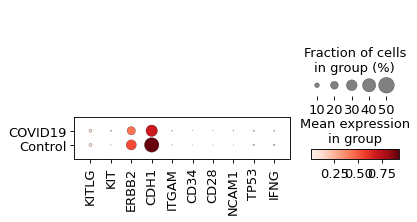

In [ ]:
sc.pl.dotplot(ann, marker_genes, groupby='Disease', save='covid.svg')

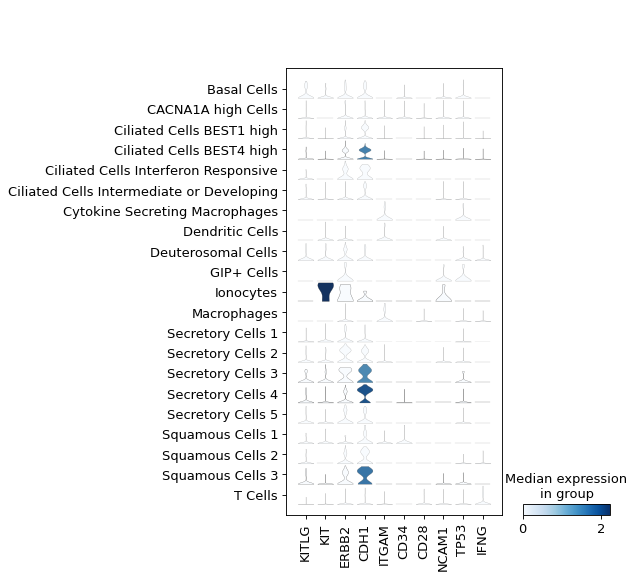

In [ ]:
sc.pl.stacked_violin(ann, marker_genes, groupby='Annotation', rotation=90, save='AllNasalEpithelia.svg')

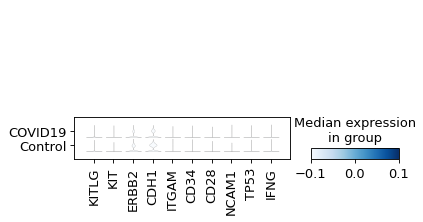

In [ ]:
sc.pl.stacked_violin(ann, marker_genes, groupby='Disease', rotation=90, save='covid.svg')